In [ ]:
getwd()
setwd('..')
getwd()

In [2]:
import pandas as pd
import numpy as np
from scipy.io import mmread

import matplotlib.pyplot as plt

In [3]:
dataset_original_all=[
'Kohinbulk_filtered',
'HumanLiver_filtered',
'Zhengmix8eq_filtered'
]

In [4]:
dataset_simul_all=[]
for ncells_total in [1000,2000,5000,10000]:
    for prop in ['1e-2','5e-3','1e-3','5e-4']:
        for i in range(1,10+1):
            dataset_simul_all.append('Simul_{}_{}_{}_filtered'.format(ncells_total,prop,i))

In [29]:
#0.01, 0.005, 0.001, 0.0005 0.0001

In [30]:
dataset_tabula_all=["TabulaAorta_filtered", #ok
"TabulaBladder_filtered", #ok
"TabulaBrainMyeloid_filtered", #ok
                  
"TabulaBrainNonMyeloid_filtered",#ok
"TabulaDiaphragm_filtered", #ok

"TabulaFat_filtered", #ok
"TabulaHeart_filtered", #ok

"TabulaKidney_filtered", #ok
"TabulaLargeIntestine_filtered", #ok
"TabulaLimbMuscle_filtered", #ok

"TabulaLiver_filtered", #ok
"TabulaLung_filtered", #ok

"TabulaMammaryGland_filtered", #ok
"TabulaMarrow_filtered", #ok

"TabulaPancreas_filtered", #ok
"TabulaSkin_filtered", #ok
                  
"TabulaSpleen_filtered", #ok
"TabulaThymus_filtered", #ok
                  
"TabulaTongue_filtered", #ok
"TabulaTrachea_filtered"] #ok

In [5]:
#dataset_name_all=dataset_original_all+dataset_tabula_all+dataset_simul_all
dataset_name_all=dataset_simul_all
#dataset_name_all=dataset_original_all+dataset_tabula_all

In [31]:
dataset_name_all=['Splatter_5000_1_filtered']

In [6]:
for dataset_name in dataset_name_all[:]:
    path='datasets/extract/{}'.format(dataset_name)
    print(path)
    
    
    exp_data=mmread('{}.data.counts.mm'.format(path)).toarray().astype(float)
    with open('{}.data.col'.format(path),'r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
    with open('{}.data.row'.format(path),'r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]
    assert exp_data.shape==(len(exp_data_row),len(exp_data_col))
    assert len(set(exp_data_row))==len(exp_data_row)
    assert len(set(exp_data_col))==len(exp_data_col)


    metadatarow=pd.read_csv('{}.metadatarow.tsv'.format(path),sep='\t')
    metadatacol=pd.read_csv('{}.metadatacol.tsv'.format(path),sep='\t')
    assert exp_data.shape==(metadatarow.shape[0],metadatacol.shape[0])

    cell_size_factor=pd.read_csv('{}.size_factor.tsv'.format(path),sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
    assert exp_data.shape[1]==cell_size_factor.shape[0]       
    
    
    
    exp_data_df=pd.DataFrame(exp_data)
    exp_data_df.index=exp_data_row
    exp_data_df.columns=exp_data_col
    exp_data_df.shape    

    exp_data_pertype_mean=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.mean(axis=0))
    exp_data_pertype_detect=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.mean(axis=0))
    exp_data_pertype_var=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.var(axis=0))

    exp_data_pertype_onehot=exp_data_pertype_mean.copy()
    exp_data_pertype_onehot.iloc[:,:]=np.nan    
    

    exp_data_pertype_maxdiff=[]
    exp_data_pertype_nonzeromin=[]

    for j in range(exp_data_pertype_mean.shape[1]):
        #col_diff=np.log2(exp_data_pertype.iloc[:,j]+1).sort_values().diff()
        col_diff=np.log10(exp_data_pertype_mean.iloc[:,j][exp_data_pertype_mean.iloc[:,j]!=0]).sort_values().diff()


        if len(col_diff)==0:  # all values are zero
            maxdiff=0
            nonzeromin=0

            bound_value=np.inf

            print(col_diff.name,'all zero')

        elif len(col_diff)==1: # only one value is not zero
            #col_diff.iloc[0]=np.log2(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0])
            maxdiff=np.inf
            nonzeromin=exp_data_pertype_mean.iloc[:,j][col_diff.index[0]]

            bound_value=nonzeromin

            print(col_diff.name,'only one value',bound_value)

            if np.all(exp_data_pertype_mean.iloc[:,j]<1):
                maxdiff=0
                print('maxdiff set as 0(all types are < 1)',exp_data_pertype_mean.iloc[:,j].values)        

        else:
            maxdiff=col_diff.max()
            nonzeromin=exp_data_pertype_mean.iloc[:,j][col_diff.index[0]]

            bound_value=exp_data_pertype_mean.iloc[:,j][col_diff.idxmax()]

        exp_data_pertype_maxdiff.append(maxdiff)
        exp_data_pertype_nonzeromin.append(nonzeromin)
        #    #print(col_diff)

        exp_data_pertype_onehot.iloc[(exp_data_pertype_mean.iloc[:,j]  >= bound_value).values,j] = 1
        exp_data_pertype_onehot.iloc[(exp_data_pertype_mean.iloc[:,j] < bound_value).values,j] = 0 

    exp_data_pertype_maxdiff=np.array(exp_data_pertype_maxdiff)
    exp_data_pertype_nonzeromin=np.array(exp_data_pertype_nonzeromin)

    assert exp_data_pertype_onehot.isnull().sum().sum()==0    

    exp_data_pertype_nonzeromin,exp_data_pertype_maxdiff

    crit_overone=(((exp_data_pertype_mean>1)).sum(axis=0)>0).values
    
    #thres_maxdiff=np.max([np.log10(4 if 'Simul' not in dataset_name else 2),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-200/np.sum([crit_overone]))])
    break
    ###########
    for logfold in [2,3,4]:
        for top_n in [100,200,300,400,500]:
            #thres_maxdiff=np.log10(logfold)
            #cut by max(log10(4), top200)
            #thres_maxdiff=np.max([np.log10(logfold),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-top_n/np.sum([crit_overone]))])
            thres_maxdiff=np.max([np.log10(logfold),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-np.min([np.sum([crit_overone]),top_n])/np.sum([crit_overone]))])
            
            crit_maxdiff=(exp_data_pertype_maxdiff>thres_maxdiff)

            marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit_maxdiff].columns

            print('crit_overone: {} '.format(np.sum(crit_overone)))
            print('crit_maxdiff: {} thres_maxdiff: {}'.format(np.sum(crit_maxdiff),thres_maxdiff))

            print('marker onehot shape:',exp_data_pertype_onehot.astype(int)[marker_maxdiff].shape)
            print('marker onehot sum:\n',exp_data_pertype_onehot.astype(int)[marker_maxdiff].sum(axis=1))
            print('marker onehot sum:\n',exp_data_pertype_onehot.astype(int)[marker_maxdiff].sum(axis=0))

            pd.Series(exp_data_pertype_maxdiff,index=exp_data_row).to_csv('{}.maxdiff.{}.{}.tsv'.format(path,top_n,logfold),sep='\t')
            exp_data_pertype_onehot.astype(int)[marker_maxdiff].to_csv('{}.markerrho.{}.{}.tsv'.format(path,top_n,logfold),sep='\t') 
    

datasets/extract/Simul_1000_1e-2_1_filtered


In [7]:
for logfold in [2,3,4]:
    for top_n in [100,200,300,400,500]:
        #thres_maxdiff=np.log10(logfold)
        #cut by max(log10(4), top200)
        #thres_maxdiff=np.max([np.log10(logfold),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-top_n/np.sum([crit_overone]))])
        thres_maxdiff=np.max([np.log10(logfold),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-np.min([np.sum([crit_overone]),top_n])/np.sum([crit_overone]))])

        crit_maxdiff=(exp_data_pertype_maxdiff>thres_maxdiff)

        marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit_maxdiff].columns

        print('crit_overone: {} '.format(np.sum(crit_overone)))
        print('crit_maxdiff: {} thres_maxdiff: {}'.format(np.sum(crit_maxdiff),thres_maxdiff))

        print('marker onehot shape:',exp_data_pertype_onehot.astype(int)[marker_maxdiff].shape)
        print('marker onehot sum:\n',exp_data_pertype_onehot.astype(int)[marker_maxdiff].sum(axis=1))
        print('marker onehot sum:\n',exp_data_pertype_onehot.astype(int)[marker_maxdiff].sum(axis=0))
        break
        pd.Series(exp_data_pertype_maxdiff,index=exp_data_row).to_csv('{}.maxdiff.{}.{}.tsv'.format(path,top_n,logfold),sep='\t')
        exp_data_pertype_onehot.astype(int)[marker_maxdiff].to_csv('{}.markerrho.{}.{}.tsv'.format(path,top_n,logfold),sep='\t') 


crit_overone: 1500 
crit_maxdiff: 89 thres_maxdiff: 0.3010299956639812
marker onehot shape: (9, 89)
marker onehot sum:
 1    73
2    70
3    61
4    29
5    62
6    56
7    44
8    51
9    51
dtype: int64
marker onehot sum:
 3143    8
96      6
1982    6
2586    6
3573    6
       ..
1681    7
4594    8
110     1
4020    1
3307    8
Length: 89, dtype: int64
crit_overone: 1500 
crit_maxdiff: 42 thres_maxdiff: 0.47712125471966244
marker onehot shape: (9, 42)
marker onehot sum:
 1    35
2    34
3    31
4     2
5    31
6    29
7    31
8    28
9    36
dtype: int64
marker onehot sum:
 3143    8
96      6
1982    6
2910    3
4636    8
678     1
3660    6
4808    8
1171    8
1643    8
2335    7
4269    8
628     8
1808    8
3228    1
2271    3
473     3
4509    8
1520    3
3213    8
65      1
3188    8
964     1
1848    8
3880    8
4371    8
674     8
814     3
3095    8
1271    8
2843    8
109     8
1926    7
4915    8
2056    8
942     2
2706    8
267     8
2453    3
504     8
110     1
3307

In [9]:
exp_data_pertype_onehot.astype(int)[marker_maxdiff]

,96,1982,4636,678,1171,3228,473,4509,3213,65,...,3095,1271,2843,109,1926,2056,2706,267,110,3307
1,1,1,1,0,1,0,1,1,1,0,...,1,1,1,1,1,1,1,1,0,1
2,1,1,1,0,1,0,1,1,1,0,...,1,1,1,1,0,1,1,1,0,1
3,1,1,1,0,1,0,0,1,1,0,...,1,1,1,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,1,0,1,1,1,0,...,1,1,1,1,1,1,1,1,0,1
6,1,1,1,0,1,0,0,1,1,0,...,1,1,1,1,1,1,1,1,0,1
7,1,1,1,0,1,0,0,1,1,0,...,1,1,1,1,1,1,1,1,0,1
8,0,0,1,0,1,0,0,1,1,0,...,1,1,1,1,1,1,1,1,0,1
9,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [12]:
((exp_data_pertype_mean>1)).sum(axis=0)

ENSG00000251562    8
ENSG00000167526    8
ENSG00000140988    8
ENSG00000147403    8
ENSG00000142541    8
                  ..
ENSG00000253626    0
ENSG00000147162    0
ENSG00000166046    0
ENSG00000133027    0
ENSG00000183751    0
Length: 4714, dtype: int64

In [14]:
exp_data_pertype_mean

,ENSG00000251562,ENSG00000167526,ENSG00000140988,ENSG00000147403,ENSG00000142541,ENSG00000205542,ENSG00000166710,ENSG00000137154,ENSG00000231500,ENSG00000164587,...,ENSG00000160218,ENSG00000095209,ENSG00000156711,ENSG00000171206,ENSG00000109606,ENSG00000253626,ENSG00000147162,ENSG00000166046,ENSG00000133027,ENSG00000183751
b.cells,42.192385,26.238477,23.615230,21.092184,23.591182,13.364729,11.797595,15.410822,18.418838,12.793587,...,0.014028,0.030060,0.018036,0.020040,0.012024,0.028056,0.022044,0.018036,0.028056,0.010020
cd14.monocytes,10.638333,13.498333,15.888333,10.841667,10.945000,18.483333,7.513333,7.660000,7.195000,8.958333,...,0.006667,0.008333,0.000000,0.031667,0.010000,0.035000,0.010000,0.018333,0.023333,0.026667
cd4.t.helper,23.580000,25.902500,25.572500,24.562500,20.022500,16.937500,21.647500,19.277500,13.507500,11.740000,...,0.010000,0.035000,0.032500,0.027500,0.022500,0.015000,0.010000,0.012500,0.025000,0.035000
cd56.nk,63.510000,14.186667,11.356667,15.993333,13.241667,22.710000,29.866667,10.526667,11.298333,10.735000,...,0.068333,0.016667,0.033333,0.010000,0.038333,0.011667,0.041667,0.038333,0.023333,0.018333
memory.t,26.936000,28.634000,24.414000,25.132000,23.356000,23.566000,24.410000,19.426000,20.482000,17.570000,...,0.022000,0.008000,0.018000,0.020000,0.018000,0.014000,0.022000,0.020000,0.016000,0.014000
naive.cytotoxic,25.015075,31.864322,26.846734,26.288945,23.462312,16.002513,16.907035,23.002513,20.819095,19.231156,...,0.005025,0.032663,0.010050,0.007538,0.010050,0.005025,0.010050,0.010050,0.027638,0.012563
naive.t,24.086172,25.224449,22.879760,22.931864,19.106212,13.332665,14.663327,18.080160,11.909820,11.306613,...,0.012024,0.030060,0.016032,0.020040,0.032064,0.012024,0.014028,0.004008,0.026052,0.018036
regulatory.t,22.919679,23.198795,22.524096,22.524096,17.431727,16.273092,21.530120,17.094378,11.831325,10.052209,...,0.014056,0.012048,0.034137,0.022088,0.020080,0.036145,0.024096,0.026104,0.012048,0.026104


1.0

In [13]:
path

'datasets/extract/Zhengmix8eq_filtered'

In [9]:
1-top_n/np.sum([crit_overone])

-0.06382978723404253

In [11]:
np.sum([crit_overone])

282

In [25]:
np.log10(2)

0.3010299956639812

In [22]:
crit_maxdiff

array([False, False, False, ..., False, False,  True])

<AxesSubplot:>

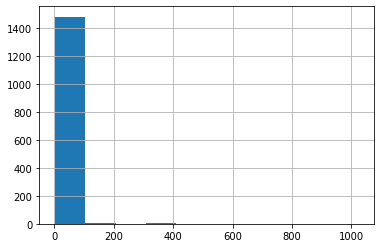

In [21]:
exp_data_df.mean(axis=1).hist()

In [18]:
pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: (x>0).mean())#.mean(axis=0))

,2266,129,4409,3968,1644,638,117,2720,4654,802,...,2582,567,1274,629,169,868,2185,4835,4143,2226
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.220000,0.420000,0.200000,0.220000,0.220000,0.160000,0.080000,0.500000,0.600000,0.140000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.262295,0.340164,0.303279,0.331967,0.307377,0.331967,0.286885,0.590164,0.586066,0.286885
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.250000,0.389344,0.483607,0.483607,0.471311,0.487705,0.483607,0.627049,0.581967,0.520492
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.233607,0.397541,0.225410,0.254098,0.241803,0.213115,0.176230,0.553279,0.553279,0.245902
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.115226,0.440329,0.567901,0.522634,0.572016,0.547325,0.559671,0.518519,0.592593,0.604938
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.290984,0.483607,0.127049,0.122951,0.114754,0.180328,0.147541,0.549180,0.516393,0.168033
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.188525,0.389344,0.176230,0.135246,0.213115,0.188525,0.172131,0.532787,0.569672,0.200820
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.258197,0.385246,0.426230,0.438525,0.459016,0.418033,0.430328,0.512295,0.577869,0.422131
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.209877,0.370370,0.423868,0.469136,0.423868,0.456790,0.452675,0.617284,0.506173,0.469136


In [14]:
metadatacol['phenoid'].values

array([1, 1, 1, ..., 9, 9, 9])

In [ ]:
for dataset_name in dataset_name_all[:1]:
    path='datasets/extract/{}'.format(dataset_name)
    print(path)
    
    
    exp_data=mmread('{}.data.counts.mm'.format(path)).toarray().astype(float)
    with open('{}.data.col'.format(path),'r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
    with open('{}.data.row'.format(path),'r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]
    assert exp_data.shape==(len(exp_data_row),len(exp_data_col))
    assert len(set(exp_data_row))==len(exp_data_row)
    assert len(set(exp_data_col))==len(exp_data_col)


    metadatarow=pd.read_csv('{}.metadatarow.tsv'.format(path),sep='\t')
    metadatacol=pd.read_csv('{}.metadatacol.tsv'.format(path),sep='\t')
    assert exp_data.shape==(metadatarow.shape[0],metadatacol.shape[0])

    cell_size_factor=pd.read_csv('{}.size_factor.tsv'.format(path),sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
    assert exp_data.shape[1]==cell_size_factor.shape[0]       
    
    
    
    exp_data_df=pd.DataFrame(exp_data)
    exp_data_df.index=exp_data_row
    exp_data_df.columns=exp_data_col
    exp_data_df.shape    

    exp_data_pertype=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.mean(axis=0))
    exp_data_pertype_detect=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.mean(axis=0))
    exp_data_pertype_var=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.var(axis=0))

    exp_data_pertype_onehot=exp_data_pertype.copy()
    exp_data_pertype_onehot.iloc[:,:]=np.nan    
    

    exp_data_pertype_maxdiff=[]
    exp_data_pertype_nonzeromin=[]

    for j in range(exp_data_pertype.shape[1]):
        #col_diff=np.log2(exp_data_pertype.iloc[:,j]+1).sort_values().diff()
        col_diff=np.log10(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0]).sort_values().diff()


        if len(col_diff)==0:  # all values are zero
            maxdiff=0
            nonzeromin=0

            bound_value=np.inf

            print(col_diff.name,'all zero')

        elif len(col_diff)==1: # only one value is not zero
            #col_diff.iloc[0]=np.log2(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0])
            maxdiff=np.inf
            nonzeromin=exp_data_pertype.iloc[:,j][col_diff.index[0]]

            bound_value=nonzeromin

            print(col_diff.name,'only one value',bound_value)

            if np.all(exp_data_pertype.iloc[:,j]<1):
                maxdiff=0
                print('maxdiff set as 0(all types are < 1)',exp_data_pertype.iloc[:,j].values)        

        else:
            maxdiff=col_diff.max()
            nonzeromin=exp_data_pertype.iloc[:,j][col_diff.index[0]]

            bound_value=exp_data_pertype.iloc[:,j][col_diff.idxmax()]

        exp_data_pertype_maxdiff.append(maxdiff)
        exp_data_pertype_nonzeromin.append(nonzeromin)
        #    #print(col_diff)

        exp_data_pertype_onehot.iloc[(exp_data_pertype.iloc[:,j]  >= bound_value).values,j] = 1
        exp_data_pertype_onehot.iloc[(exp_data_pertype.iloc[:,j] < bound_value).values,j] = 0 

    exp_data_pertype_maxdiff=np.array(exp_data_pertype_maxdiff)
    exp_data_pertype_nonzeromin=np.array(exp_data_pertype_nonzeromin)

    assert exp_data_pertype_onehot.isnull().sum().sum()==0    

    exp_data_pertype_nonzeromin,exp_data_pertype_maxdiff

    crit_overone=(((exp_data_pertype>1)).sum(axis=0)>0).values
    thres_maxdiff=np.max([np.log10(4 if 'Simul' not in dataset_name else 2),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-200/np.sum([crit_overone]))])
    #cut by max(log10(4), top200)
    crit_maxdiff=(exp_data_pertype_maxdiff>thres_maxdiff)

    marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit_maxdiff].columns

    #print('crit_overone: {} '.format(np.sum(crit_overone)))
    print('crit_maxdiff: {} thres_maxdiff: {}'.format(np.sum(crit_maxdiff),thres_maxdiff))

    print('marker onehot shape:',exp_data_pertype_onehot.astype(int)[marker_maxdiff].shape)
    print('marker onehot sum:\n',exp_data_pertype_onehot.astype(int)[marker_maxdiff].sum(axis=1))
    
    pd.Series(exp_data_pertype_maxdiff,index=exp_data_row).to_csv('{}.maxdiff.tsv'.format(path),sep='\t')
    exp_data_pertype_onehot.astype(int)[marker_maxdiff].to_csv('{}.markerrho.tsv'.format(path),sep='\t')    
    

In [19]:
exp_data_pertype.iloc[:,12316]

APS                3.825180
D2LtM              2.069836
D5CntrlDrmmtm      1.628232
DLL1pPXM           1.132874
ESMT               1.250620
MPS                0.952063
Sclrtm           167.683781
hESC               1.523107
Name: ENSG00000099260, dtype: float64

In [20]:
exp_data_pertype.iloc[:,782]

APS               279.315567
D2LtM             544.655077
D5CntrlDrmmtm     890.389258
DLL1pPXM          213.274503
ESMT              258.785049
MPS               314.983134
Sclrtm           7312.960064
hESC               92.544917
Name: ENSG00000185070, dtype: float64

In [48]:
dataset_name='Kohinbulk_filtered'

path='datasets/extract/{}'.format(dataset_name)
print(path)


exp_data=mmread('{}.data.counts.mm'.format(path)).toarray().astype(float)
with open('{}.data.col'.format(path),'r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
with open('{}.data.row'.format(path),'r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]
assert exp_data.shape==(len(exp_data_row),len(exp_data_col))
assert len(set(exp_data_row))==len(exp_data_row)
assert len(set(exp_data_col))==len(exp_data_col)


metadatarow=pd.read_csv('{}.metadatarow.tsv'.format(path),sep='\t')
metadatacol=pd.read_csv('{}.metadatacol.tsv'.format(path),sep='\t')
assert exp_data.shape==(metadatarow.shape[0],metadatacol.shape[0])

cell_size_factor=pd.read_csv('{}.size_factor.tsv'.format(path),sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
assert exp_data.shape[1]==cell_size_factor.shape[0]       



exp_data_df=pd.DataFrame(exp_data)
exp_data_df.index=exp_data_row
exp_data_df.columns=exp_data_col
exp_data_df.shape    

exp_data_pertype=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.mean(axis=0))

datasets/extract/Kohinbulk_filtered


In [ ]:
a=exp_data_pertype.loc[['APS','MPS']].apply(lambda x: np.log10(x)).diff().abs().iloc[1]
#.sort_values()#loc['ENSG00000225840']

In [63]:
a[a!=np.inf].sort_values().iloc[-50:]

ENSG00000101224    1.302514
ENSG00000110446    1.316392
ENSG00000140557    1.317040
ENSG00000154553    1.325340
ENSG00000163235    1.327473
ENSG00000106341    1.342447
ENSG00000108352    1.347537
ENSG00000260261    1.356944
ENSG00000107611    1.360912
ENSG00000196668    1.361201
ENSG00000178209    1.373327
ENSG00000169306    1.375296
ENSG00000196782    1.389432
ENSG00000179104    1.404357
ENSG00000231134    1.416744
ENSG00000124444    1.419240
ENSG00000074211    1.420291
ENSG00000162733    1.435737
ENSG00000116667    1.438632
ENSG00000139292    1.459948
ENSG00000233822    1.464107
ENSG00000182752    1.483262
ENSG00000241316    1.504527
ENSG00000196793    1.509283
ENSG00000197043    1.516685
ENSG00000171970    1.518605
ENSG00000259223    1.580624
ENSG00000280623    1.581070
ENSG00000186340    1.595509
ENSG00000162849    1.641407
ENSG00000188659    1.696830
ENSG00000125266    1.697772
ENSG00000282988    1.712982
ENSG00000143333    1.723714
ENSG00000168843    1.769324
ENSG00000273802    1

In [56]:
exp_data_pertype.loc[['APS','MPS']].apply(lambda x: np.log2(x)).diff().iloc[1].loc['ENSG00000225840']

1.9648531163702412

In [28]:
exp_data_pertype=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: np.log2(np.mean(np.expm1(x),axis=0)))

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in expm1
  """Entry point for launching an IPython kernel.


In [37]:
exp_data_pertype.loc[['APS','MPS']]#.diff().iloc[1]#.sort_values()

,ENSG00000198804,ENSG00000210082,ENSG00000198712,ENSG00000198938,ENSG00000198727,ENSG00000211459,ENSG00000156508,ENSG00000198899,ENSG00000198886,ENSG00000075624,...,ENSG00000069712,ENSG00000277151,ENSG00000272381,ENSG00000137842,ENSG00000109684,ENSG00000249937,ENSG00000217120,ENSG00000166323,ENSG00000258102,ENSG00000233866
APS,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,97.601492,23.662577,4.748402,88.816440,12.868192,6.129725,12.693437,67.607541,3.000427,16.156990
MPS,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,225.781101,19.571578,10.309292,37.132303,10.381416,35.882056,3.286888,79.232989,61.281874,6.019241


In [47]:
np.expm1(100)

2.6881171418161356e+43

In [44]:
exp_data[:,metadatacol['phenoid'].values=='APS']

array([[3.89286749e+04, 2.80240696e+04, 5.79787103e+04, ...,
        2.96301064e+04, 3.81840331e+04, 4.28815458e+04],
       [7.01212313e+04, 3.83771313e+04, 5.31217928e+04, ...,
        2.84073747e+04, 4.05178718e+04, 5.55008681e+04],
       [3.26057457e+04, 2.47297650e+04, 3.94058076e+04, ...,
        2.15332319e+04, 2.24443891e+04, 4.03644029e+04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.06672748e+00, 0.00000000e+00, 0.00000000e+00],
       [1.79915508e+00, 0.00000000e+00, 1.28714864e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.48579768e-01, 0.00000000e+00, 2.86281384e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [38]:
exp_data_pertype.loc[['APS','MPS']]['ENSG00000225840']

APS    inf
MPS    inf
Name: ENSG00000225840, dtype: float64

In [36]:
exp_data_pertype.loc[['APS','MPS']].diff().iloc[1].loc['ENSG00000225840']

nan

In [18]:
exp_data_pertype.loc[['APS','MPS']].apply(np.log2).diff().iloc[1].loc['ENSG00000280623']

5.252200490676531

In [7]:
exp_data.shape,(metadatarow.shape[0],metadatacol.shape[0])

((6002, 8444), (6001, 8444))

'datasets/extract/Zhengmix8eq_filtered'

(array([1.06383333e+01, 1.34983333e+01, 1.13566667e+01, ...,
        4.00801603e-03, 1.20481928e-02, 1.00200401e-02]),
 array([0.33333493, 0.21358507, 0.15156903, ..., 0.39924747, 0.1638568 ,
        0.15347257]))

In [24]:
np.log10(2)

0.3010299956639812

crit_maxdiff: 562 thres_maxdiff: 0.6020599913279624
marker onehot shape: (8, 68)
marker onehot sum:
 b.cells            22
cd14.monocytes     32
cd4.t.helper       20
cd56.nk            32
memory.t           20
naive.cytotoxic    19
naive.t            18
regulatory.t       20
dtype: int64


/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [11]:
exp_data_pertype_onehot.astype(int)[marker_maxdiff]

,ENSG00000156966,ENSG00000280623,ENSG00000241186,ENSG00000204262,ENSG00000254339,ENSG00000116729,ENSG00000106392,ENSG00000145386,ENSG00000136014,ENSG00000115461,...,ENSG00000076662,ENSG00000100084,ENSG00000151322,ENSG00000136383,ENSG00000175592,ENSG00000266074,ENSG00000123570,ENSG00000148795,ENSG00000187801,ENSG00000231333
APS,1,0,1,1,0,1,1,1,0,0,...,1,1,0,0,1,1,0,0,1,1
D2LtM,1,0,0,1,0,1,1,1,0,0,...,0,0,1,1,1,1,0,0,0,1
D5CntrlDrmmtm,0,0,0,1,0,1,1,1,0,1,...,1,1,1,0,0,1,1,0,1,1
DLL1pPXM,1,0,0,1,0,1,1,1,0,0,...,1,1,1,0,1,1,1,0,1,1
ESMT,1,0,0,1,0,1,1,0,0,1,...,1,1,1,0,0,1,1,0,1,0
MPS,1,1,1,0,0,1,1,1,0,0,...,1,0,1,0,1,1,0,0,1,1
Sclrtm,1,0,0,1,0,1,0,1,0,1,...,0,1,1,0,0,1,1,1,0,1
hESC,1,0,1,1,1,0,1,1,1,0,...,1,1,1,0,1,0,1,0,1,1


In [14]:
exp_data_pertype[marker_maxdiff]

,ENSG00000156966,ENSG00000280623,ENSG00000241186,ENSG00000204262,ENSG00000254339,ENSG00000116729,ENSG00000106392,ENSG00000145386,ENSG00000136014,ENSG00000115461,...,ENSG00000076662,ENSG00000100084,ENSG00000151322,ENSG00000136383,ENSG00000175592,ENSG00000266074,ENSG00000123570,ENSG00000148795,ENSG00000187801,ENSG00000231333
APS,565.712918,97.290662,499.231906,74.067885,186.833172,71.190849,102.352366,66.381393,78.775660,10.551224,...,4.062958,10.419241,0.633409,8.236965,10.885246,2.356840,0.855026,1.527973,8.745694,4.465514
D2LtM,145.089285,248.973573,26.845071,51.929186,12.586452,51.743316,196.627864,72.572160,47.105929,4.261182,...,0.106265,0.021597,11.257210,178.767063,4.144072,7.945615,0.895188,1.713344,0.000000,11.705397
D5CntrlDrmmtm,3.465386,71.652458,3.675909,77.132798,2.947503,121.236156,56.681790,45.791695,34.129385,155.404206,...,14.115960,5.404130,49.472822,5.880988,0.299654,5.684050,10.813095,1.222501,4.798541,6.716007
DLL1pPXM,214.247414,43.437779,26.047022,85.256352,27.673654,75.477535,117.557938,57.917841,44.461136,4.939537,...,9.679097,18.139159,16.619016,3.852409,3.378589,4.938591,10.538234,1.966052,9.965726,6.282122
ESMT,88.583446,101.341749,10.380757,118.406856,15.158925,109.198073,72.986838,3.315760,40.217952,257.037470,...,6.637440,4.595085,9.654865,2.592719,0.173271,1.813334,20.435939,1.135348,3.983131,0.177492
MPS,2838.755076,3708.011308,593.722468,3.930483,190.034516,111.729494,189.873690,135.705507,36.888200,5.188922,...,4.117274,0.056876,11.300290,11.582302,10.026318,31.964912,0.086072,1.708221,3.555192,2.736397
Sclrtm,49.865450,39.435307,19.311065,526.124733,6.713389,67.161975,3.760757,40.123233,13.997212,680.421923,...,0.086047,1.455396,84.456329,0.657350,0.278266,2.647567,20.312845,28.155762,0.058726,23.032903
hESC,2486.889935,137.065017,2110.410205,61.722108,2229.268358,3.086532,529.160841,134.229634,1068.419529,4.224024,...,15.520460,6.080802,11.355651,15.506078,24.563982,0.055002,18.551315,1.291510,37.727991,2.095627


In [29]:
metadatacol['phenoid'].value_counts()

DLL1pPXM         74
Sclrtm           68
D5CntrlDrmmtm    67
APS              62
D2LtM            55
hESC             55
ESMT             43
MPS              22
Name: phenoid, dtype: int64

(array([350.,  34.,  29.,  12.,  10.,   4.,   4.,   1.,   1.,   1.]),
 array([   0.        ,  815.67984157, 1631.35968314, 2447.03952471,
        3262.71936628, 4078.39920784, 4894.07904941, 5709.75889098,
        6525.43873255, 7341.11857412, 8156.79841569]),
 <a list of 10 Patch objects>)

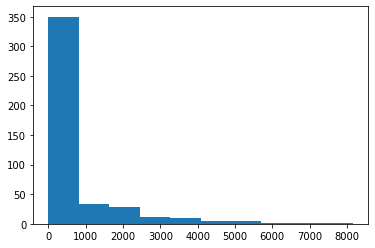

In [27]:
plt.hist(exp_data[exp_data_row.index(marker_maxdiff[0])])

In [20]:
exp_data_row.index(marker_maxdiff[0])

1735

In [13]:
marker_maxdiff

Index(['ENSG00000156966', 'ENSG00000280623', 'ENSG00000241186',
       'ENSG00000204262', 'ENSG00000254339', 'ENSG00000116729',
       'ENSG00000106392', 'ENSG00000145386', 'ENSG00000136014',
       'ENSG00000115461',
       ...
       'ENSG00000076662', 'ENSG00000100084', 'ENSG00000151322',
       'ENSG00000136383', 'ENSG00000175592', 'ENSG00000266074',
       'ENSG00000123570', 'ENSG00000148795', 'ENSG00000187801',
       'ENSG00000231333'],
      dtype='object', length=200)

In [13]:
dataset_name_all[-1:]

['Zhengmix8eq_filtered']

In [13]:
'{}_filtered.maxdiff.tsv'.format(path)

'datasets/extract/Kohinbulk_filtered_filtered.maxdiff.tsv'

In [16]:
for i,dataset_name in enumerate(dataset_name_all[-1:]):
    if dataset_name!='Trapnell':
        #continue    
        pass
    
    print('----------------------------------------')

    #dataset_name='Zhengmix8eq'
    print(dataset_name)
    
    
    exp_data=mmread('datasets/extract/{}.data.counts.mm'.format(dataset_name)).toarray().astype(float)
    with open('datasets/extract/{}.data.col'.format(dataset_name),'r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
    with open('datasets/extract/{}.data.row'.format(dataset_name),'r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]

    assert exp_data.shape==(len(exp_data_row),len(exp_data_col))
    assert len(set(exp_data_row))==len(exp_data_row)
    assert len(set(exp_data_col))==len(exp_data_col)     

    metadatarow=pd.read_csv('datasets/extract/{}.metadatarow.tsv'.format(dataset_name),sep='\t')
    metadatacol=pd.read_csv('datasets/extract/{}.metadatacol.tsv'.format(dataset_name),sep='\t')
    assert exp_data.shape==(metadatarow.shape[0],metadatacol.shape[0])

    cell_size_factor=pd.read_csv('datasets/extract/{}.size_factor.tsv'.format(dataset_name),sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
    assert exp_data.shape[1]==cell_size_factor.shape[0]   
    
    
    exp_data_df=pd.DataFrame(exp_data)
    exp_data_df.index=exp_data_row
    exp_data_df.columns=exp_data_col
    exp_data_df.shape    
    
    exp_data_pertype=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.mean(axis=0))
    exp_data_pertype_var=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.var(axis=0))
    
    exp_data_pertype_onehot=exp_data_pertype.copy()
    exp_data_pertype_onehot.iloc[:,:]=np.nan

    exp_data_pertype_maxdiff=[]
    exp_data_pertype_nonzeromin=[]
    
    for j in range(exp_data_pertype.shape[1]):
        #col_diff=np.log2(exp_data_pertype.iloc[:,j]+1).sort_values().diff()
        col_diff=np.log10(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0]).sort_values().diff()
        
        
        if len(col_diff)==0:
            maxdiff=0
            nonzeromin=0
            
            bound_value=np.inf
        
            print(col_diff.name,'all zero')
        elif len(col_diff)==1:
            #col_diff.iloc[0]=np.log2(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0])
            maxdiff=np.inf
            nonzeromin=exp_data_pertype.iloc[:,j][col_diff.index[0]]
            
            bound_value=nonzeromin
            
            print(col_diff.name,'only one value',bound_value)
        else:
            maxdiff=col_diff.max()
            nonzeromin=exp_data_pertype.iloc[:,j][col_diff.index[0]]
            
            bound_value=exp_data_pertype.iloc[:,j][col_diff.idxmax()]
        
        exp_data_pertype_maxdiff.append(maxdiff)
        exp_data_pertype_nonzeromin.append(nonzeromin)
        #    #print(col_diff)
    
        exp_data_pertype_onehot.iloc[(exp_data_pertype.iloc[:,j]  >= bound_value).values,j] = 1
        exp_data_pertype_onehot.iloc[(exp_data_pertype.iloc[:,j] < bound_value).values,j] = 0 

    exp_data_pertype_maxdiff=np.array(exp_data_pertype_maxdiff)
    exp_data_pertype_nonzeromin=np.array(exp_data_pertype_nonzeromin)
    
    assert exp_data_pertype_onehot.isnull().sum().sum()==0

    
    crit_overone=((exp_data_pertype>1).sum(axis=0)>0).values
    thres_maxdiff=np.max([np.log10(4),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-200/np.sum(crit_overone))])
    crit_maxdiff=(exp_data_pertype_maxdiff>thres_maxdiff)
    
    marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit_maxdiff].columns
        
    print('crit_overone: {} '.format(np.sum(crit_overone)))
    print('crit_maxdiff: {} thres_maxdiff: {}'.format(np.sum(crit_maxdiff),thres_maxdiff))
    
    print('marker onehot shape:',exp_data_pertype_onehot.astype(int)[marker_maxdiff].shape)
    print('marker onehot sum:\n',exp_data_pertype_onehot.astype(int)[marker_maxdiff].sum(axis=1))
    
    pd.Series(exp_data_pertype_maxdiff,index=exp_data_row).to_csv('datasets/extract/{}_filtered.maxdiff.tsv'.format(dataset_name),sep='\t')
    exp_data_pertype_onehot.astype(int)[marker_maxdiff].to_csv('datasets/extract/{}_filtered.markerrho.tsv'.format(dataset_name),sep='\t')
    #break

----------------------------------------
Zhengmix8eq_filtered
ENSG00000085265 only one value 1.8866666666666667
ENSG00000106565 only one value 0.8366666666666667
ENSG00000100079 only one value 0.8233333333333334
ENSG00000197249 only one value 0.49333333333333335
ENSG00000247982 only one value 0.5551102204408818
ENSG00000002933 only one value 0.36
ENSG00000104921 only one value 0.44488977955911824
ENSG00000119535 only one value 0.27166666666666667
ENSG00000163221 only one value 0.25666666666666665
ENSG00000150687 only one value 0.365
ENSG00000185215 only one value 0.21666666666666667
ENSG00000141505 only one value 0.21833333333333332
ENSG00000162444 only one value 0.205
ENSG00000180739 only one value 0.31166666666666665
ENSG00000171051 only one value 0.17
ENSG00000198574 only one value 0.24166666666666667
ENSG00000224397 only one value 0.16666666666666666
ENSG00000158825 only one value 0.145
ENSG00000121552 only one value 0.14333333333333334
ENSG00000038427 only one value 0.118333333333

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:93: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [17]:
np.log10(4)

0.6020599913279624

In [7]:
for i,dataset_name in enumerate(dataset_name_all):
    if dataset_name!='Trapnell':
        continue    
    
    print('----------------------------------------')

    #dataset_name='Zhengmix8eq'
    print(dataset_name)
    
    
    exp_data=mmread('datasets/extract/{}_filtered.data.counts.mm'.format(dataset_name)).toarray().astype(float)
    with open('datasets/extract/{}_filtered.data.col'.format(dataset_name),'r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
    with open('datasets/extract/{}_filtered.data.row'.format(dataset_name),'r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]

    assert exp_data.shape==(len(exp_data_row),len(exp_data_col))
    assert len(set(exp_data_row))==len(exp_data_row)
    assert len(set(exp_data_col))==len(exp_data_col)     

    metadatarow=pd.read_csv('datasets/extract/{}_filtered.metadatarow.tsv'.format(dataset_name),sep='\t')
    metadatacol=pd.read_csv('datasets/extract/{}_filtered.metadatacol.tsv'.format(dataset_name),sep='\t')
    assert exp_data.shape==(metadatarow.shape[0],metadatacol.shape[0])

    cell_size_factor=pd.read_csv('datasets/extract/{}_filtered.size_factor.tsv'.format(dataset_name),sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
    assert exp_data.shape[1]==cell_size_factor.shape[0]   
    
    
    exp_data_df=pd.DataFrame(exp_data)
    exp_data_df.index=exp_data_row
    exp_data_df.columns=exp_data_col
    exp_data_df.shape    
    
    exp_data_pertype=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.mean(axis=0))
    exp_data_pertype_var=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.var(axis=0))
    
    exp_data_pertype_onehot=exp_data_pertype.copy()
    exp_data_pertype_onehot.iloc[:,:]=np.nan

    exp_data_pertype_maxdiff=[]
    exp_data_pertype_nonzeromin=[]
    
    for j in range(exp_data_pertype.shape[1]):
        #col_diff=np.log2(exp_data_pertype.iloc[:,j]+1).sort_values().diff()
        col_diff=np.log10(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0]).sort_values().diff()
        
        
        if len(col_diff)==0:
            maxdiff=0
            nonzeromin=0
            
            bound_value=np.inf
        
            print(col_diff.name,'all zero')
        elif len(col_diff)==1:
            #col_diff.iloc[0]=np.log2(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0])
            maxdiff=np.inf
            nonzeromin=exp_data_pertype.iloc[:,j][col_diff.index[0]]
            
            bound_value=nonzeromin
            
            print(col_diff.name,'only one value',bound_value)
        else:
            maxdiff=col_diff.max()
            nonzeromin=exp_data_pertype.iloc[:,j][col_diff.index[0]]
            
            bound_value=exp_data_pertype.iloc[:,j][col_diff.idxmax()]
        
        exp_data_pertype_maxdiff.append(maxdiff)
        exp_data_pertype_nonzeromin.append(nonzeromin)
        #    #print(col_diff)
    
        exp_data_pertype_onehot.iloc[(exp_data_pertype.iloc[:,j]  >= bound_value).values,j] = 1
        exp_data_pertype_onehot.iloc[(exp_data_pertype.iloc[:,j] < bound_value).values,j] = 0 

    exp_data_pertype_maxdiff=np.array(exp_data_pertype_maxdiff)
    exp_data_pertype_nonzeromin=np.array(exp_data_pertype_nonzeromin)
    
    assert exp_data_pertype_onehot.isnull().sum().sum()==0

    
    crit_overone=((exp_data_pertype>1).sum(axis=0)>0).values
    thres_maxdiff=np.max([np.log10(4),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-200/np.sum(crit_overone))])
    crit_maxdiff=(exp_data_pertype_maxdiff>thres_maxdiff)
    
    marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit_maxdiff].columns
        
    print('crit_overone: {} '.format(np.sum(crit_overone)))
    print('crit_maxdiff: {} thres_maxdiff: {}'.format(np.sum(crit_maxdiff),thres_maxdiff))
    
    print('marker onehot shape:',exp_data_pertype_onehot.astype(int)[marker_maxdiff].shape)
    print('marker onehot sum:\n',exp_data_pertype_onehot.astype(int)[marker_maxdiff].sum(axis=1))
    
    pd.Series(exp_data_pertype_maxdiff,index=exp_data_row).to_csv('datasets/extract/{}_filtered.maxdiff.tsv'.format(dataset_name),sep='\t')
    exp_data_pertype_onehot.astype(int)[marker_maxdiff].to_csv('datasets/extract/{}_filtered.markerrho.tsv'.format(dataset_name),sep='\t')
    #break

----------------------------------------
Trapnell
crit_overone: 12333 
crit_maxdiff: 200 thres_maxdiff: 0.6166513694190856
marker onehot shape: (3, 200)
marker onehot sum:
 T0     100
T24    120
T48    104
dtype: int64


/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:92: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [12]:
#exp_data_pertype.iloc[:,crit_overone&crit_maxdiff].T
#exp_data_pertype_onehot.astype(int)[marker_maxdiff]
#exp_data
#exp_data_row
np.sum(crit_overone)

12333

In [11]:
np.log10(4),pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-200/np.sum(crit_overone))

(0.6020599913279624, 0.6166513694190856)

In [24]:
np.sum(crit_maxdiff),np.sum(crit_maxdiff&crit_overone)

(582, 68)

(array([3.511e+03, 8.090e+02, 2.180e+02, 8.500e+01, 3.300e+01, 2.100e+01,
        1.400e+01, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([0.01670569, 0.38284141, 0.74897714, 1.11511286, 1.48124858,
        1.8473843 , 2.21352002, 2.57965574, 2.94579146, 3.31192718,
        3.6780629 ]),
 <a list of 10 Patch objects>)

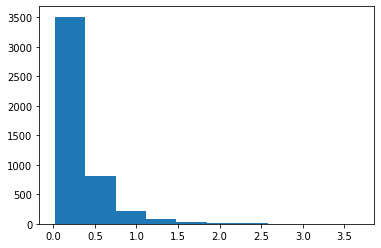

In [21]:
plt.hist(exp_data_pertype_maxdiff[exp_data_pertype_maxdiff!=np.inf])

In [16]:
for i,dataset_name in enumerate(dataset_name_all):
    #dataset_name='Kohinbulk'
    dataset_name='Zhengmix8eq'
    print(dataset_name)
    
    
    exp_data=mmread('datasets/extract/{}_filtered.data.counts.mm'.format(dataset_name)).toarray().astype(float)
    with open('datasets/extract/{}_filtered.data.col'.format(dataset_name),'r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
    with open('datasets/extract/{}_filtered.data.row'.format(dataset_name),'r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]

    assert exp_data.shape==(len(exp_data_row),len(exp_data_col))
    assert len(set(exp_data_row))==len(exp_data_row)
    assert len(set(exp_data_col))==len(exp_data_col)     

    metadatarow=pd.read_csv('datasets/extract/{}_filtered.metadatarow.tsv'.format(dataset_name),sep='\t')
    metadatacol=pd.read_csv('datasets/extract/{}_filtered.metadatacol.tsv'.format(dataset_name),sep='\t')
    assert exp_data.shape==(metadatarow.shape[0],metadatacol.shape[0])

    cell_size_factor=pd.read_csv('datasets/extract/{}_filtered.size_factor.tsv'.format(dataset_name),sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
    assert exp_data.shape[1]==cell_size_factor.shape[0]   
    
    
    exp_data_df=pd.DataFrame(exp_data)
    exp_data_df.index=exp_data_row
    exp_data_df.columns=exp_data_col
    exp_data_df.shape    
    
    exp_data_pertype=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.mean(axis=0))
    exp_data_pertype_var=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.var(axis=0))
    
    exp_data_pertype_onehot=exp_data_pertype.copy()
    exp_data_pertype_onehot.iloc[:,:]=np.nan

    exp_data_pertype_maxdiff=[]
    exp_data_pertype_nonzeromin=[]
    
    for j in range(exp_data_pertype.shape[1]):
        #col_diff=np.log2(exp_data_pertype.iloc[:,j]+1).sort_values().diff()
        col_diff=np.log10(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0]).sort_values().diff()
        
        
        if len(col_diff)==0:
            maxdiff=0
            nonzeromin=0
            
            bound_value=np.inf
        
            print(col_diff.name,'all zero')
        elif len(col_diff)==1:
            #col_diff.iloc[0]=np.log2(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0])
            maxdiff=np.inf
            nonzeromin=exp_data_pertype.iloc[:,j][col_diff.index[0]]
            
            bound_value=nonzeromin
            
            print(col_diff.name,'only one value',bound_value)
        else:
            maxdiff=col_diff.max()
            nonzeromin=exp_data_pertype.iloc[:,j][col_diff.index[0]]
            
            bound_value=exp_data_pertype.iloc[:,j][col_diff.idxmax()]
        
        exp_data_pertype_maxdiff.append(maxdiff)
        exp_data_pertype_nonzeromin.append(nonzeromin)
        #    #print(col_diff)
    
        exp_data_pertype_onehot.iloc[(exp_data_pertype.iloc[:,j]  >= bound_value).values,j] = 1
        exp_data_pertype_onehot.iloc[(exp_data_pertype.iloc[:,j] < bound_value).values,j] = 0 

    exp_data_pertype_maxdiff=np.array(exp_data_pertype_maxdiff)
    exp_data_pertype_nonzeromin=np.array(exp_data_pertype_nonzeromin)
    
    assert exp_data_pertype_onehot.isnull().sum().sum()==0

    
    crit_overone=((exp_data_pertype>1).sum(axis=0)>0).values
    thres_maxdiff=np.max([2.0,pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-200/np.sum(crit_overone))])
    crit_maxdiff=(exp_data_pertype_maxdiff>thres_maxdiff)
    
    marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit_maxdiff].columns
    
    print('thres_maxdiff: ',thres_maxdiff)
    print('marker onehot shape:',exp_data_pertype_onehot.astype(int)[marker_maxdiff].shape)
    print('marker onehot sum:\n',exp_data_pertype_onehot.astype(int)[marker_maxdiff].sum(axis=1))
    
    exp_data_pertype_onehot.astype(int)[marker_maxdiff].to_csv('datasets/extract/{}_filtered.markerrho.tsv'.format(dataset_name),sep='\t')
    break

Zhengmix8eq
ENSG00000085265 only one value 1.8866666666666667
ENSG00000106565 only one value 0.8366666666666667
ENSG00000100079 only one value 0.8233333333333334
ENSG00000197249 only one value 0.49333333333333335
ENSG00000247982 only one value 0.5551102204408818
ENSG00000002933 only one value 0.36
ENSG00000104921 only one value 0.44488977955911824
ENSG00000119535 only one value 0.27166666666666667
ENSG00000163221 only one value 0.25666666666666665
ENSG00000150687 only one value 0.365
ENSG00000185215 only one value 0.21666666666666667
ENSG00000141505 only one value 0.21833333333333332
ENSG00000162444 only one value 0.205
ENSG00000180739 only one value 0.31166666666666665
ENSG00000171051 only one value 0.17
ENSG00000198574 only one value 0.24166666666666667
ENSG00000224397 only one value 0.16666666666666666
ENSG00000158825 only one value 0.145
ENSG00000121552 only one value 0.14333333333333334
ENSG00000038427 only one value 0.11833333333333333
ENSG00000166523 only one value 0.105
thres_m

In [12]:
#exp_data_df.loc['ENSG00000085265']
exp_data_pertype['ENSG00000085265']

b.cells            0.000000
cd14.monocytes     1.886667
cd4.t.helper       0.000000
cd56.nk            0.000000
memory.t           0.000000
naive.cytotoxic    0.000000
naive.t            0.000000
regulatory.t       0.000000
Name: ENSG00000085265, dtype: float64

In [7]:
exp_data_pertype_onehot.astype(int)[marker_maxdiff]

,ENSG00000227507,ENSG00000019582,ENSG00000133639,ENSG00000213402,ENSG00000111716,ENSG00000196126,ENSG00000008517,ENSG00000011600,ENSG00000126264,ENSG00000204287,...,ENSG00000180644,ENSG00000170458,ENSG00000159674,ENSG00000156738,ENSG00000150045,ENSG00000172116,ENSG00000203747,ENSG00000100450,ENSG00000100721,ENSG00000254709
b.cells,1,1,1,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
cd14.monocytes,0,1,0,0,0,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
cd4.t.helper,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
cd56.nk,0,0,1,1,0,0,1,1,1,0,...,1,0,1,0,1,0,1,1,0,0
memory.t,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
naive.cytotoxic,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
naive.t,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
regulatory.t,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [769]:
crit_overone=((exp_data_pertype>1).sum(axis=0)>0).values
thres_maxdiff=np.max([2.0,pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-200/np.sum(crit_overone))])
crit_maxdiff=(exp_data_pertype_maxdiff>thres_maxdiff)
print(thres_maxdiff)

marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit_maxdiff].columns

3.4532501021745428


Cholangiocytes             38
Erythroid cells            11
Hepatic Stellate Cells     30
Hepatocytes               114
LSECs                      32
Macrophages                30
Mature B cells              7
NK cells                   10
Plasma cells               22
ab T cells                 10
gd T cells                 13
dtype: int64

In [772]:
exp_data_pertype_onehot.astype(int)[marker_maxdiff].shape

(11, 200)

In [738]:
crit_overone=((exp_data_pertype>1).sum(axis=0)>0).values

In [739]:
value1=np.max([2.0,pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-100/np.sum(crit_overone))])
crit1=(exp_data_pertype_maxdiff>value1)

print(value1,np.sum(crit1))

marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit1].columns

4.358759100194587 156


'PDE4B'

In [499]:
len(col_diff)==1

True

In [496]:
np.log2(exp_data_pertype.iloc[:,j][exp_data_pertype.iloc[:,j]!=0]).sort_values().diff()

cd14.monocytes   NaN
Name: ENSG00000085265, dtype: float64

In [495]:
col_diff

cd14.monocytes   NaN
Name: ENSG00000085265, dtype: float64

In [475]:
exp_data_pertype_var=pd.DataFrame(exp_data_df).T.groupby(metadatacol['phenoid'].values).apply(lambda x: x.var(axis=0))

In [257]:
value1=(pd.Series(exp_data_pertype_maxdiff).quantile(1-200/exp_data.shape[0]))
crit1=(exp_data_pertype_maxdiff>value1)
print(value1,np.sum(crit1))

2.705627204547677 200


In [259]:
value1=1#(pd.Series(exp_data_pertype_maxdiff).quantile(1-50/exp_data.shape[0]))
crit1=(exp_data_pertype_maxdiff>value1)
print(value1,np.sum(crit1))

1 4901


In [253]:
exp_data_pertype_var.iloc[:,crit1]

,ENSG00000251562,ENSG00000177954,ENSG00000087086,ENSG00000133112,ENSG00000167996,ENSG00000227507,ENSG00000019582,ENSG00000133639,ENSG00000111716,ENSG00000104894,...,ENSG00000197766,ENSG00000180644,ENSG00000170458,ENSG00000159674,ENSG00000156738,ENSG00000150045,ENSG00000172116,ENSG00000203747,ENSG00000100450,ENSG00000254709
b.cells,226.272151,42.471401,12.030583,11.270895,8.204320,30.324802,83.398588,2.700968,0.715270,10.543006,...,0.000000,0.000000,0.000000,0.005988,2.981698,0.005988,0.000000,0.000000,0.000000,28.390508
cd14.monocytes,94.394855,11.465417,90.240598,5.217337,96.146775,0.444271,391.184304,0.517251,0.729190,2.238261,...,1.829647,0.000000,2.154922,0.004983,0.000000,0.003328,0.000000,0.008322,0.000000,32.971619
cd4.t.helper,94.800602,18.584405,10.669167,10.764856,9.786159,16.973208,23.559893,3.213477,4.041197,1.265658,...,0.002500,0.029449,0.002500,0.024662,0.000000,0.000000,0.017387,0.002500,0.004987,0.000000
cd56.nk,226.046644,79.069238,9.046533,14.423815,4.561578,1.922359,1.245273,2.587635,0.616984,0.919265,...,0.000000,2.826311,0.000000,1.935448,0.001667,1.219474,0.006633,1.501825,2.597860,0.000000
memory.t,112.777459,57.335547,11.348521,16.229515,10.834806,24.761539,1.471166,2.866834,3.793487,1.292741,...,0.005976,0.009920,0.000000,0.009920,0.009984,0.000000,0.003992,0.000000,0.021944,0.000000
naive.cytotoxic,94.967027,40.579219,12.133539,13.292717,4.799995,5.724897,0.492057,3.077510,2.878802,0.972824,...,0.009974,0.009974,0.002513,0.007500,0.002513,0.000000,1.938711,0.000000,0.000000,0.000000
naive.t,94.821877,15.963035,10.090092,12.135935,4.634715,8.093939,1.779326,4.559255,3.051581,1.176691,...,0.004000,0.007968,0.000000,0.007968,0.000000,0.000000,0.017746,0.000000,0.000000,53.943944
regulatory.t,88.874823,16.482396,10.415489,12.453468,7.567594,15.127730,2.235582,3.913040,2.628320,1.452377,...,0.002008,0.021806,0.004008,0.009959,0.000000,0.002008,0.004008,0.000000,0.000000,0.000000


In [267]:
value1=(pd.Series(exp_data_pertype_maxdiff).quantile(1-100/exp_data.shape[0]))
crit1=(exp_data_pertype_maxdiff>value1)
print(value1,np.sum(crit1))

3.103947124264257 100


In [264]:
value2=exp_data_pertype.max()[exp_data_pertype.max()!=0].quantile(0.5)
#value2=1
crit2=(exp_data_pertype.max()>=value2).values
print(value2,np.sum(crit2))

63.49008841785109 7347


In [261]:
exp_data_pertype_new=exp_data_pertype.copy()
exp_data_pertype_new.loc['a']=exp_data_pertype_maxdiff

In [230]:
np.sum(crit1&crit2)

100

In [235]:
exp_data_pertype_var.iloc[:,crit1&crit2]

,ENSG00000177954,ENSG00000087086,ENSG00000133112,ENSG00000167996,ENSG00000227507,ENSG00000019582,ENSG00000133639,ENSG00000104894,ENSG00000185201,ENSG00000196126,...,ENSG00000085265,ENSG00000169583,ENSG00000171476,ENSG00000137441,ENSG00000197766,ENSG00000180644,ENSG00000159674,ENSG00000156738,ENSG00000172116,ENSG00000100450
b.cells,42.471401,12.030583,11.270895,8.204320,30.324802,83.398588,2.700968,10.543006,0.756235,19.294219,...,0.000000,0.002004,0.076539,0.000000,0.000000,0.000000,0.005988,2.981698,0.000000,0.000000
cd14.monocytes,11.465417,90.240598,5.217337,96.146775,0.444271,391.184304,0.517251,2.238261,0.721992,112.232821,...,3.993812,0.108044,0.009972,0.000000,1.829647,0.000000,0.004983,0.000000,0.000000,0.000000
cd4.t.helper,18.584405,10.669167,10.764856,9.786159,16.973208,23.559893,3.213477,1.265658,1.181648,7.951479,...,0.000000,0.062149,0.202406,0.029850,0.002500,0.029449,0.024662,0.000000,0.017387,0.004987
cd56.nk,79.069238,9.046533,14.423815,4.561578,1.922359,1.245273,2.587635,0.919265,7.751583,0.066099,...,0.000000,5.589583,3.283737,4.066642,0.000000,2.826311,1.935448,0.001667,0.006633,2.597860
memory.t,57.335547,11.348521,16.229515,10.834806,24.761539,1.471166,2.866834,1.292741,1.781964,0.487391,...,0.000000,0.076389,0.198232,0.008000,0.005976,0.009920,0.009920,0.009984,0.003992,0.021944
naive.cytotoxic,40.579219,12.133539,13.292717,4.799995,5.724897,0.492057,3.077510,0.972824,1.115559,0.012537,...,0.000000,0.046030,0.002513,0.005012,0.009974,0.009974,0.007500,0.002513,1.938711,0.000000
naive.t,15.963035,10.090092,12.135935,4.634715,8.093939,1.779326,4.559255,1.176691,0.931228,0.053891,...,0.000000,0.002004,0.005988,0.000000,0.004000,0.007968,0.007968,0.000000,0.017746,0.000000
regulatory.t,16.482396,10.415489,12.453468,7.567594,15.127730,2.235582,3.913040,1.452377,1.043546,0.754164,...,0.000000,0.015951,0.078095,0.000000,0.002008,0.021806,0.009959,0.000000,0.004008,0.000000


In [268]:
exp_data_pertype_new.iloc[:,crit1&crit2]

,ENSG00000143320,ENSG00000156966,ENSG00000215866,ENSG00000280623,ENSG00000141449,ENSG00000241186,ENSG00000204262,ENSG00000254339,ENSG00000116729,ENSG00000106392,...,ENSG00000181449,ENSG00000281579,ENSG00000005102,ENSG00000106078,ENSG00000178031,ENSG00000116132,ENSG00000198807,ENSG00000168843,ENSG00000229183,ENSG00000136383
APS,115.274194,565.712918,510.667741,97.290662,13.705266,499.231906,74.067885,186.833172,71.190849,102.352366,...,2.113516,4.378264,0.029774,4.988878,3.370687,1.938601,2.520309,3.892790,0.123849,8.236965
D2LtM,133.958740,145.089285,334.360974,248.973573,333.762911,26.845071,51.929186,12.586452,51.743316,196.627864,...,0.000000,0.396155,0.032819,0.081152,2.453868,2.026686,0.453434,1.237014,0.039920,178.767063
D5CntrlDrmmtm,433.759162,3.465386,2.820468,71.652458,186.093091,3.675909,77.132798,2.947503,121.236156,56.681790,...,3.365898,0.000000,1.655995,10.577243,3.089998,136.989723,0.320279,0.085740,5.127903,5.880988
DLL1pPXM,390.630865,214.247414,344.916802,43.437779,394.908684,26.047022,85.256352,27.673654,75.477535,117.557938,...,0.308714,0.716414,0.728648,3.398459,0.805450,0.589493,0.463843,0.077773,1.843572,3.852409
ESMT,193.392642,88.583446,32.526996,101.341749,279.316926,10.380757,118.406856,15.158925,109.198073,72.986838,...,0.397461,0.472504,145.251975,2.074505,14.579138,0.687539,0.000000,0.295063,122.055163,2.592719
MPS,95.373831,2838.755076,761.569593,3708.011308,2.608502,593.722468,3.930483,190.034516,111.729494,189.873690,...,0.397348,6.468600,0.000000,2.771032,0.979301,1.223446,5.817742,0.066212,0.036156,11.582302
Sclrtm,9.761860,49.865450,18.008198,39.435307,153.904038,19.311065,526.124733,6.713389,67.161975,3.760757,...,5.378773,0.103856,14.823828,7.278380,155.917469,0.576238,86.276840,72.745882,5.368508,0.657350
hESC,101.972714,2486.889935,376.350792,137.065017,11.207030,2110.410205,61.722108,2229.268358,3.086532,529.160841,...,63.755091,72.709447,0.859250,109.603054,1.033483,1.053964,0.755526,4.753113,0.948538,15.506078
a,3.162714,3.509829,3.322320,3.891187,3.396970,4.167103,3.424263,3.545312,3.690039,3.598853,...,3.343643,3.302940,3.208286,3.256028,3.332319,5.510678,3.678233,3.680148,4.272206,3.445059


In [238]:
exp_data_pertype_onehot.iloc[:,crit1&crit2]

,ENSG00000177954,ENSG00000087086,ENSG00000133112,ENSG00000167996,ENSG00000227507,ENSG00000019582,ENSG00000133639,ENSG00000104894,ENSG00000185201,ENSG00000196126,...,ENSG00000085265,ENSG00000169583,ENSG00000171476,ENSG00000137441,ENSG00000197766,ENSG00000180644,ENSG00000159674,ENSG00000156738,ENSG00000172116,ENSG00000100450
b.cells,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
cd14.monocytes,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
cd4.t.helper,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cd56.nk,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
memory.t,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
naive.cytotoxic,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
naive.t,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
regulatory.t,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


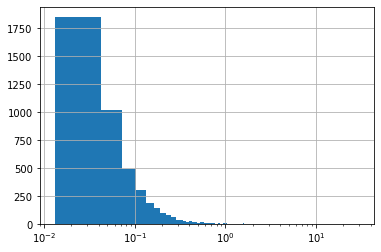

In [99]:
plt.xscale('log')
exp_data_pertype.mean().hist(bins=1000)


In [70]:
pd.Series(exp_data_pertype_maxdiff).shape

(4714,)

0.021213406873143825

0.014028056112224449 3021


In [78]:
np.sum(crit1&crit2)

0

In [79]:
crit1

array([False, False, False, ..., False, False, False])

In [80]:
crit2

array([ True,  True,  True, ..., False, False, False])

In [24]:
exp_data_pertype_onehot.iloc[:,crit1]

,ENSG00000251562,ENSG00000167526,ENSG00000140988,ENSG00000147403,ENSG00000142541,ENSG00000205542,ENSG00000166710,ENSG00000137154,ENSG00000231500,ENSG00000164587,...,ENSG00000113649,ENSG00000160218,ENSG00000095209,ENSG00000171206,ENSG00000109606,ENSG00000253626,ENSG00000147162,ENSG00000166046,ENSG00000133027,ENSG00000183751
b.cells,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
cd14.monocytes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
cd4.t.helper,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
cd56.nk,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
memory.t,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
naive.cytotoxic,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
naive.t,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
regulatory.t,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


In [19]:
value0=2
crit0=(exp_data_pertype_maxdiff>value0).values
print(value0,np.sum(crit0))

value1=exp_data_pertype_maxdiff[exp_data_pertype_maxdiff!=np.inf].quantile(0.9)
crit1=(exp_data_pertype_maxdiff>value1).values
print(value1,np.sum(crit1))

value2=exp_data_pertype.min()[exp_data_pertype.min()!=0].quantile(0.5)
crit2=(exp_data_pertype.min()>value2).values
print(value2,np.sum(crit2))

crit3=exp_data_pertype_maxdiff!=np.inf
print(np.sum(crit3))

print(np.sum(crit0&crit1&crit2&crit3))  

2 669
1.8479969065549504 759
0.02404809619238477 2184
4394
45


In [530]:
value0=2
crit0=(exp_data_pertype_maxdiff>value0).values
print(value0,np.sum(crit0))

#value1=exp_data_pertype_maxdiff[exp_data_pertype_maxdiff!=np.inf].quantile(0.9)
value1=2.2
crit1=(exp_data_pertype_maxdiff>value1).values
print(value1,np.sum(crit1))

value2=exp_data_pertype.min()[exp_data_pertype.min()!=0].quantile(0.5)
crit2=(exp_data_pertype.min()>value2).values
print(value2,np.sum(crit2))

print(np.sum(crit0&crit1&crit2))  

2 1300
2.2 1001
9.591775132257252 7339
66


In [732]:
clustername_to_markers_old={'Hepatocytes':['ALB','HAMP','ARG1','PCK1','AFP','BCHE'],
'LSECs':['CALCRL','FCGR2B','VWF'],
'Cholangiocytes':['KRT19','EPCAM','FXYD2','CLDN4','CLDN10','SOX9','MMP7','CXCL1','CFTR','TFF2','KRT7','CD24'],
'Hepatic_Stellate_Cells':['ACTA2','COL1A1','TAGLN','COL1A2','COL3A1','SPARC','RBP1','DCN','MYL9'],
'Macrophages':['CD68','MARCO'],
'ab_T_cells':['CD2','CD3D','TRAC','IL32','CD3E'],
'gd_T_cells':['NKG7','FCGR3A','HOPX','GNLY'],
'NK_cells':['GZMK','KLRF1','CCL3','CMC1'],
'Plasma_cells':['CD27','IGHG1'],
'Mature_B_cells':['MS4A1','LTB','CD52','IGHD'],
'Erythroid_cells':['HBB','SLC25A37','CA1','ALAS2']  
}

marker_unique=np.unique([j for i in list(clustername_to_markers_old.values()) for j in i])
marker_unique_=[]
for marker in marker_unique:
    try:
        exp_data_row.index(marker)
        marker_unique_.append(marker)
    except:
        print(marker)
marker_unique=np.unique(marker_unique_)
marker_unique
answer1=pd.Index(marker_unique)

ACTA2
ALAS2
CFTR
CLDN10
CLDN4
COL1A1
COL1A2
COL3A1
CXCL1
DCN
EPCAM
FXYD2
IGHD
KRT19
KRT7
MMP7
MS4A1
MYL9
SOX9
TFF2


In [733]:
deg_supple=pd.read_csv('datasets/41467_2018_6318_MOESM5_ESM.csv')
deg_supple=deg_supple.iloc[1:,[3*cl for cl in range(int((len(deg_supple.columns)+1)/3))]]
deg_supple_flat=pd.Series(deg_supple.values.flatten())
deg_supple_flat=deg_supple_flat[~deg_supple_flat.isnull()].reset_index()[0]
answer2=pd.Index(np.unique(deg_supple_flat))
answer2=answer2.intersection(exp_data_row)

In [734]:
dataset_name

'HumanLiver'

In [735]:
deg_result=pd.read_csv('datasets/extract/{}_filtered.deg.wilcox.tsv'.format(dataset_name),sep='\t')
deg_result.index=list(map(lambda x: x if x in exp_data_row else '.'.join(x.split('.')[:-1]), deg_result.index))
set(deg_result.index).issubset(exp_data_row)

#m2=deg_result.sort_values('myAUC',ascending=False).iloc[:100].index
m1=deg_result.sort_values('p_val').iloc[:100].index
len(m1)

100

In [736]:
len(answer1),len(answer1.intersection(m1)),len(answer2),len(answer2.intersection(m1))

(35, 6, 294, 23)

In [737]:
pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-100/np.sum(crit_overone))

IndexError: Item wrong length 4714 instead of 6002.

In [738]:
crit_overone=((exp_data_pertype>1).sum(axis=0)>0).values

In [739]:
value1=np.max([2.0,pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-100/np.sum(crit_overone))])
crit1=(exp_data_pertype_maxdiff>value1)

print(value1,np.sum(crit1))

marker_maxdiff=exp_data_pertype_onehot.iloc[:,crit_overone&crit1].columns

4.358759100194587 156


In [740]:
print(pd.Series(exp_data_pertype_maxdiff)[crit_overone].quantile(1-100/np.sum(crit_overone)))

4.358759100194587


In [741]:
pd.Series(exp_data_pertype_maxdiff).iloc[crit_overone&crit1]#.sort_values()

22      5.089777
26      5.649854
32      4.517937
52      5.273889
61      4.824914
          ...   
5362    6.005605
5813    6.628758
5911    4.748444
5979    7.696898
6000    4.965757
Length: 100, dtype: float64

In [742]:
np.log2(3.055276/0.253333)

3.5921957878995383

In [743]:
exp_data_pertype.loc[:,marker_maxdiff]

,HP,APOC3,ORM1,APOA2,APOC1,APOA1,FGB,ORM2,TF,APOH,...,PTGDS,MEG3,HBD,LGALS4,DERL3,CD79A,TNFRSF17,C11orf96,CA1,ELF3
Cholangiocytes,5.327731,4.806723,7.630252,3.663866,2.924370,3.050420,1.957983,1.588235,0.899160,1.142857,...,0.008403,0.000000,0.025210,4.546218,0.008403,0.008403,0.000000,0.000000,0.016807,3.445378
Erythroid cells,4.580645,3.290323,3.602151,1.344086,2.290323,2.161290,1.247312,0.580645,0.258065,0.451613,...,0.053763,0.000000,84.258065,0.000000,0.010753,0.010753,0.000000,0.010753,41.010753,0.010753
Hepatic Stellate Cells,5.243243,4.891892,4.405405,3.270270,3.567568,2.567568,1.567568,0.864865,0.540541,0.702703,...,2.000000,3.324324,0.000000,0.000000,0.000000,0.000000,0.000000,1.594595,0.000000,0.000000
Hepatocytes,181.433590,245.613539,174.812911,141.754927,101.115110,82.906598,50.860611,33.105398,20.618680,24.035418,...,0.004856,0.005141,0.035418,0.146530,0.017138,0.001143,0.001143,0.016567,0.011140,0.110254
LSECs,4.497630,2.791469,3.635071,1.657583,1.770142,1.861374,1.259479,0.655213,0.382701,0.469194,...,1.308057,0.899289,0.113744,0.009479,0.017773,0.010664,0.010664,0.699052,0.035545,0.001185
Macrophages,3.717282,2.252517,3.365772,1.367450,2.255872,1.692953,1.192114,0.638423,0.308725,0.484060,...,0.010067,0.041107,0.052852,0.005034,0.006711,0.012584,0.000000,0.026007,0.035235,0.007550
Mature B cells,2.596899,1.627907,2.147287,0.875969,1.023256,1.178295,0.736434,0.488372,0.232558,0.348837,...,0.007752,0.000000,0.062016,0.007752,0.077519,2.186047,0.023256,0.000000,0.031008,0.007752
NK cells,3.807377,1.682377,3.500000,1.090164,1.172131,1.438525,1.012295,0.682377,0.229508,0.360656,...,0.014344,0.000000,0.036885,0.006148,0.000000,0.004098,0.000000,0.008197,0.014344,0.000000
Plasma cells,3.465753,2.532290,3.060665,1.594912,1.252446,1.700587,1.622309,0.545988,0.420744,0.407045,...,0.011742,0.025440,0.140900,0.015656,3.479452,1.129159,2.301370,0.003914,0.197652,0.005871
ab T cells,3.522373,1.573361,3.106139,1.168574,1.229969,1.334027,0.928200,0.603538,0.203954,0.372529,...,0.012487,0.003122,0.031217,0.007284,0.005203,0.005203,0.003122,0.003122,0.008325,0.004162


In [674]:
value1=(pd.Series(exp_data_pertype_maxdiff).quantile(1-100/exp_data.shape[0]))
crit1=(exp_data_pertype_maxdiff>value1)
print(value1,np.sum(crit1))

m2=exp_data_pertype_onehot.iloc[:,crit1].columns
len(m2)

4.755040908383901 100


100

In [675]:
len(answer1),len(answer1.intersection(m2)),len(answer2),len(answer2.intersection(m2))

(35, 0, 294, 0)

In [676]:
value2=exp_data_pertype.min()[exp_data_pertype.min()!=0].quantile(0.00001)
crit2=(exp_data_pertype.min()>value2).values

crit2=((exp_data_pertype>1).sum(axis=0)>0).values
print(value2,np.sum(crit2))

m3=exp_data_pertype_onehot.iloc[:,crit2].columns
exp_data_pertype_onehot.shape,len(m3)

0.0016666666666666668 282


((8, 4714), 282)

In [677]:
len(answer1),len(answer1.intersection(m3)),len(answer2),len(answer2.intersection(m3))

(35, 0, 294, 0)

In [678]:
m4=exp_data_pertype_onehot.iloc[:,crit1&crit2].columns
len(m4)

27

In [672]:
len(answer1),len(answer1.intersection(m4)),len(answer2),len(answer2.intersection(m4))

(35, 6, 294, 39)

,ENSG00000011600,ENSG00000167286,ENSG00000115523,ENSG00000105374,ENSG00000163220,ENSG00000143546,ENSG00000101439,ENSG00000090382,ENSG00000197540,ENSG00000115738,...,ENSG00000239998,ENSG00000253701,ENSG00000038427,ENSG00000181036,ENSG00000196576,ENSG00000125538,ENSG00000123384,ENSG00000166523,ENSG00000133246,ENSG00000131042
b.cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002004,0.000000,0.004008,...,0.000000,0.446894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.002004,0.002004
cd14.monocytes,4.658333,0.000000,0.056667,0.031667,8.193333,7.941667,6.743333,5.780000,0.005000,0.565000,...,0.145000,0.056667,0.118333,0.001667,0.118333,0.123333,0.111667,0.105,0.115000,0.105000
cd4.t.helper,0.005000,1.507500,0.152500,0.072500,0.007500,0.000000,0.150000,0.092500,0.320000,0.227500,...,0.002500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
cd56.nk,4.483333,0.036667,24.448333,15.115000,0.001667,0.001667,0.033333,0.000000,1.560000,1.163333,...,0.003333,0.000000,0.000000,0.186667,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
memory.t,0.012000,2.002000,0.060000,0.068000,0.006000,0.000000,0.004000,0.000000,0.290000,0.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004000,0.000000,0.000,0.000000,0.000000
naive.cytotoxic,0.002513,1.856784,0.002513,0.037688,0.000000,0.000000,0.000000,0.000000,0.597990,0.341709,...,0.000000,0.000000,0.000000,0.000000,0.002513,0.000000,0.000000,0.000,0.000000,0.000000
naive.t,0.006012,1.322645,0.008016,0.030060,0.006012,0.000000,0.004008,0.000000,0.422846,0.178357,...,0.000000,0.002004,0.000000,0.000000,0.000000,0.000000,0.002004,0.000,0.000000,0.000000
regulatory.t,0.010040,1.487952,0.036145,0.024096,0.006024,0.000000,0.002008,0.008032,0.224900,0.174699,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000


In [627]:
for i in exp_data_pertype.min()[answer2].sort_values():
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.001999428734647244
0.0020491803278688526
0.0028563267637817767
0.0028563267637817767
0.003427592116538132
0.003427592116538132
0.003427592116538132
0.004098360655737705
0.004098360655737705
0.004098360655737705
0.004098360655737705
0.004284490145672665
0.004570122822050843
0.004570122822050843
0.00485575549842902
0.006147540983606557
0.006147540983606557
0.006147540983606557
0.006147540983606557
0.006243496357960458
0.006569551556698086
0.007029876977152899
0.007284079084287201
0.007426449585832619
0.007751937984496124
0.007751937984496124
0.007751937984496124
0.007751937984496124
0.007751937984496124
0.007751937984496124
0.007751937984496124
0.007751937984496124
0.007751937984496124
0.00819672131

In [576]:
np.sum(crit1&crit2)

0

In [545]:
pd.DataFrame([exp_data_pertype_maxdiff,exp_data_pertype_nonzeromin,]).T.sort_values(1,ascending=False)[1][:100]

0      107.324324
2       65.978148
1       58.112383
3       51.879292
6       41.135135
          ...    
100      2.774194
113      2.752688
105      2.731183
133      2.688172
22       2.596899
Name: 1, Length: 100, dtype: float64

(35, 6, 361, 41)

In [568]:
len(answer1),len(answer1.intersection(m2.union(m3))),len(answer2),len(answer2.intersection(m2.union(m3)))

(35, 6, 361, 41)

100

In [492]:
len(answer1),len(m1),len(answer1.intersection(m1)),len(m2),len(answer1.intersection(m2))

(35, 300, 11, 100, 6)

In [493]:
len(answer2),len(m1),len(answer2.intersection(m1)),len(m2),len(answer2.intersection(m2))

(361, 300, 86, 100, 23)

In [342]:
pd.Series(exp_data_pertype_maxdiff)[crit1]

12      4.250463
14      3.431346
22      4.849539
24      2.241825
26      5.387377
          ...   
4492    6.223592
4630    2.274231
4690    2.449640
4859    2.340129
5979    5.132478
Length: 100, dtype: float64

In [404]:
exp_data_pertype[marker_unique].apply(lambda x: np.log2(x[x!=0]).sort_values().diff().max()).sort_values()

CCL3        1.607046
IL32        2.157006
HOPX        2.293771
CD3E        2.371473
TRAC        2.373811
CMC1        2.497015
FCGR2B      2.579995
CD27        2.594349
NKG7        2.607744
CD3D        2.720134
FCGR3A      2.725985
CD2         2.776372
CALCRL      2.839790
CD52        2.904895
KLRF1       3.028619
LTB         3.153165
GNLY        3.278569
RBP1        3.286334
PCK1        3.353859
GZMK        3.363624
SPARC       3.496516
CD68        3.525560
ALB         3.615515
AFP         3.624491
CD24        4.105326
ARG1        4.143496
SLC25A37    4.432078
BCHE        4.481330
HAMP        4.723105
TAGLN       5.542978
HBB         6.052687
VWF         6.648226
MARCO       6.687945
CA1         7.696898
IGHG1       8.217416
dtype: float64

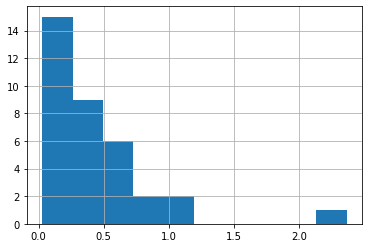

In [478]:
(exp_data_pertype/exp_data_pertype_var).loc[:,marker_unique]

,AFP,ALB,ARG1,BCHE,CA1,CALCRL,CCL3,CD2,CD24,CD27,...,LTB,MARCO,NKG7,PCK1,RBP1,SLC25A37,SPARC,TAGLN,TRAC,VWF
Cholangiocytes,NaN,0.008939,0.733270,0.808219,1.008547,1.008547,0.604096,NaN,0.110817,NaN,...,1.008547,1.000000,0.376756,0.258394,0.770496,0.607942,1.017241,1.008547,NaN,NaN
Erythroid cells,NaN,0.320182,1.038082,1.022222,0.014566,NaN,0.250215,0.371342,1.010989,NaN,...,1.010989,1.022222,0.089891,1.164557,1.010989,0.032487,1.022222,NaN,1.033708,1.000000
Hepatic Stellate Cells,1.000000,0.122715,0.769231,NaN,NaN,0.861244,1.125000,0.514286,1.000000,NaN,...,NaN,1.000000,0.128238,1.090909,0.058615,1.090909,0.024627,0.015080,0.265263,1.000000
Hepatocytes,0.745951,0.006904,0.190340,0.390182,0.102450,0.898384,0.316798,0.729490,0.517826,0.885448,...,0.952915,0.895914,0.564810,0.219962,0.895693,0.820105,0.856665,0.656142,0.549694,0.677578
LSECs,0.840646,0.029974,0.576646,0.685366,0.379616,0.347865,0.104986,0.490278,0.291821,0.886835,...,0.200535,0.655139,0.116406,0.755810,0.275365,0.544576,0.254340,0.017701,0.327590,0.034777
Macrophages,1.006762,0.188386,0.915905,0.874202,0.229919,0.597099,0.050014,0.650413,0.770616,0.502108,...,0.793499,0.041814,0.277811,0.903500,0.753104,0.533694,0.375335,0.346734,0.542580,0.665024
Mature B cells,1.007874,0.306559,1.040650,1.024000,0.401884,NaN,0.363074,NaN,0.732368,0.593540,...,0.168409,1.015873,1.066667,1.075630,1.040650,0.195225,1.007874,1.007874,1.032258,NaN
NK cells,NaN,0.311658,1.001028,1.016701,1.012474,1.004124,0.070029,0.526453,0.829015,0.909821,...,0.821651,0.851790,0.117803,0.949146,0.196671,0.652940,0.585401,0.755429,0.811913,1.012474
Plasma cells,1.000000,0.294583,0.930374,1.015936,0.013616,1.013917,0.141046,1.030303,1.017964,0.123314,...,1.017964,0.545455,0.137107,0.640915,0.845491,0.437112,0.895197,1.030303,0.490172,0.828520
ab T cells,1.002088,0.098693,0.708713,0.874981,1.007345,1.005236,0.126177,0.430335,0.601629,0.624036,...,0.099804,0.635583,0.162350,0.922539,0.838929,0.990430,0.372539,0.785873,0.398299,1.006289


In [471]:
exp_data_pertype.loc[:,marker_unique]

,AFP,ALB,ARG1,BCHE,CA1,CALCRL,CCL3,CD2,CD24,CD27,...,LTB,MARCO,NKG7,PCK1,RBP1,SLC25A37,SPARC,TAGLN,TRAC,VWF
Cholangiocytes,0.000000,81.672269,0.109244,0.058824,0.016807,0.016807,0.025210,0.000000,6.537815,0.000000,...,0.016807,0.008403,0.168067,0.352941,0.453782,0.344538,0.025210,0.016807,0.000000,0.000000
Erythroid cells,0.000000,4.827957,0.172043,0.032258,41.010753,0.000000,0.204301,0.086022,0.021505,0.000000,...,0.021505,0.032258,0.483871,0.150538,0.021505,15.806452,0.032258,0.000000,0.043011,0.010753
Hepatic Stellate Cells,0.027027,6.189189,0.135135,0.000000,0.000000,0.270270,0.135135,0.108108,0.027027,0.000000,...,0.000000,0.027027,0.594595,0.108108,5.783784,0.108108,17.945946,41.459459,0.189189,0.027027
Hepatocytes,0.333333,198.604113,3.040560,1.313910,0.011140,0.004856,0.027992,0.004570,0.026849,0.004284,...,0.009712,0.009140,0.033419,3.608398,0.020851,0.115967,0.026564,0.023993,0.004856,0.009426
LSECs,0.011848,5.052133,0.097156,0.042654,0.035545,1.322275,0.167062,0.043839,0.328199,0.016588,...,0.059242,0.037915,0.246445,0.118483,1.389810,0.732227,1.590047,3.324645,0.048578,2.710900
Macrophages,0.007550,4.516779,0.085570,0.010906,0.035235,0.037752,2.253356,0.035235,0.026007,0.010067,...,0.094799,4.014262,0.413591,0.052852,0.036913,0.182886,0.163591,0.071309,0.025168,0.019295
Mature B cells,0.015504,3.224806,0.046512,0.031008,0.031008,0.000000,0.085271,0.000000,0.379845,0.224806,...,3.348837,0.023256,0.069767,0.077519,0.046512,0.178295,0.015504,0.015504,0.038760,0.000000
NK cells,0.000000,3.151639,0.065574,0.018443,0.014344,0.006148,6.422131,0.686475,0.018443,0.227459,...,0.112705,0.038934,11.756148,0.088115,0.036885,0.043033,0.022541,0.012295,0.225410,0.014344
Plasma cells,0.001957,6.663405,0.093933,0.017613,0.197652,0.015656,0.344423,0.031311,0.019569,1.898239,...,0.019569,0.027397,0.225049,0.074364,0.019569,0.109589,0.080235,0.031311,0.060665,0.017613
ab T cells,0.003122,3.097815,0.084287,0.024974,0.008325,0.006243,0.992716,1.731530,0.006243,0.406868,...,1.891779,0.034339,3.624350,0.068678,0.019771,0.060354,0.045786,0.014568,2.064516,0.007284
